In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn
import torch
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.special import softmax
from tqdm import tqdm 
from collections import Counter
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
warnings.simplefilter("always", ConvergenceWarning)
import pickle

In [22]:
from maml.datasets.miniimagenet import MiniimagenetMetaDataset, Task
from maml.models.gated_conv_net_original import ImpRegConvModel
from maml.models.conv_embedding_model import RegConvEmbeddingModel
from maml.logistic_regression_utils import logistic_regression_grad_with_respect_to_w, logistic_regression_hessian_pieces_with_respect_to_w, logistic_regression_hessian_with_respect_to_w, logistic_regression_mixed_derivatives_with_respect_to_w_then_to_X
from maml.logistic_regression_utils import logistic_regression_mixed_derivatives_with_respect_to_w_then_to_X_left_multiply
from maml.algorithm import MetaOptnet, ProtoNet, ImpRMAML_inner_algorithm

In [27]:
def sample_indices(array, n_classes):
    for c in range(n_classes):
        np.argwhere(array==c)
def compute_variance(estimators, n_classes):
    estimators = torch.cat(estimators, dim=0).numpy()
    assert estimators.shape[1] == n_classes
    assert len(estimators.shape) == 3
    _explained_variance_ratio = []
    print("final esitimators", estimators.shape, "n_classes", n_classes)
    for i in range(n_classes):
        est = estimators[:, i, :]
        est = est / np.linalg.norm(est, axis=1)[:, None]
        est = est - est.mean(0)
        svd = TruncatedSVD(n_components=min(100, min(est.shape)), random_state=42)
        S = svd.fit(est.T @ est)
#         print(f"class: {i+1} exp. variance: ", S.explained_variance_ratio_)
#         print(f"class: {i+1} svd values : ", S.singular_values_)
        _explained_variance_ratio.append(S.explained_variance_ratio_)
    return np.stack(_explained_variance_ratio, axis=0)

In [28]:
def accuracy(preds, y):
    _, preds = torch.max(preds.data, 1)
    total = y.size(0)
    correct = (preds == y).sum().float()
    return (correct / total).item()

def get_test_performance(X, y, estimator):
    preds = X.detach().cpu() @ estimator.squeeze().T
    y = y.detach().cpu()
    return accuracy(preds, y)

In [26]:
try:
    with open('variance_stat.pkl', 'rb') as f:
        variance_stat = pickle.load(f)
except:
    variance_stat = {} 

# SVM 5w5s

MiniImagenet val
add_bias to output features :  False


  0%|          | 0/120 [00:00<?, ?it/s]

Before Modulation
tensor([16.9637, 17.5148, 16.9556, 17.3089, 17.0602, 17.6443, 17.4049, 16.2400,
        16.3001, 16.5521, 14.9721, 17.1187, 17.1497, 17.6392, 17.1182, 17.2928,
        17.7099, 16.3902, 16.3392, 16.7880, 16.4630, 16.5052, 13.6217, 14.3266,
        15.6981], device='cuda:1', grad_fn=<NormBackward1>)


100%|██████████| 120/120 [00:13<00:00,  8.86it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.87it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  9.02it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.87it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.75it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.79it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.94it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.79it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.84it/s]


final esitimators (1200, 5, 1600) n_classes 5


100%|██████████| 120/120 [00:13<00:00,  8.61it/s]


final esitimators (1200, 5, 1600) n_classes 5


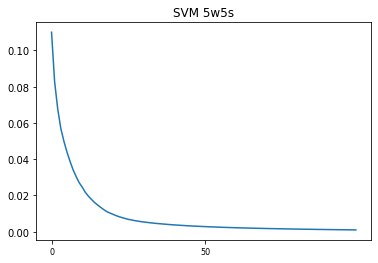

In [31]:
exp_name = 'SVM 5w5s'
chkpt = './inner_solvers/minim_5w5s_SVM/maml_impregconv_20000.pt'
torch.cuda.set_device(1)
n_runs = 10
n_way=5
n_shot=5

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        num_channels=64,
        img_side_len=dataset.input_size[1],
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = MetaOptnet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot_train=n_shot,
    n_shot_val=n_shot,
    device='cuda')


# start variance computation
explained_variance_ratio = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            estimator = algorithm.inner_loop_adapt(
                support=samples_x, 
                support_labels=samples_y, 
                query=samples_x,
                return_estimator=True
            ).detach().cpu()
            estimators.append(estimator)
    explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))

variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)

with open('variance_stat.pkl', 'wb') as f:
    pickle.dump(variance_stat, f)
    
    
plt.plot(variance_stat[exp_name])
plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
plt.title(exp_name)
plt.show()

# SVM 5w1s

In [ ]:
exp_name = 'SVM 5w1s'
chkpt = './inner_solvers/minim_5w1s_SVM/maml_impregconv_22000.pt'
torch.cuda.set_device(1)
n_runs = 2
n_way=5
n_shot=1

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        output_size=dataset.output_size,
        num_channels=64,
        img_side_len=dataset.input_size[1],
        use_max_pool=False, # currently not used
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = MetaOptnet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot_train=n_shot,
    n_shot_val=n_shot,
    device='cuda')


# start variance computation
explained_variance_ratio = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            estimators.append(algorithm.inner_loop_adapt(
                support=samples_x, 
                support_labels=samples_y, 
                query=samples_x,
                return_estimator=True
            ).detach().cpu())
    explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))

variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)

with open('variance_stat.pkl', 'wb') as f:
    pickle.dump(variance_stat, f)
    
    
plt.plot(variance_stat[exp_name])
plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
plt.title(exp_name)
plt.show()

# Protonet 5w5s

In [ ]:
exp_name = 'protonet 5w5s'
chkpt = './inner_solvers/minim_5w5s_protonet/maml_impregconv_8000.pt'
torch.cuda.set_device(1)
n_runs = 10
n_way=5
n_shot=5

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        output_size=dataset.output_size,
        num_channels=64,
        img_side_len=dataset.input_size[1],
        use_max_pool=False, # currently not used
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = ProtoNet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot_train=n_shot,
    n_shot_val=n_shot,
    device='cuda')


# start variance computation
explained_variance_ratio = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            estimators.append(algorithm.inner_loop_adapt(
                support=samples_x, 
                support_labels=samples_y, 
                query=samples_x,
                return_estimator=True
            ).detach().cpu())
    explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))

variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)

with open('variance_stat.pkl', 'wb') as f:
    pickle.dump(variance_stat, f)

plt.plot(variance_stat[exp_name])
plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
plt.title(exp_name)
plt.show()



# Protonet 5w1s

In [13]:
exp_name = 'Protonet 5w1s test on 5w5s'
chkpt = './inner_solvers/minim_5w1s_protonet/maml_impregconv_20000.pt'
torch.cuda.set_device(1)
n_runs = 2
n_way=5
n_shot=1

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        num_channels=64,
        img_side_len=dataset.input_size[1],
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = ProtoNet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot_train=n_shot,
    n_shot_val=n_shot,
    device='cuda')


# start variance computation
explained_variance_ratio = []
perf_mean = []
perf_var = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            test_indices = np.random.choice(3000, 100, replace=False)
            estimator = algorithm.inner_loop_adapt(
                support=samples_x, 
                support_labels=samples_y, 
                query=samples_x,
                return_estimator=True
            ).unsqueeze(0).detach().cpu()
            perf.append(
                get_test_performance(
                    model(train_task_batch_x[0, test_indices], modulation=None), 
                    train_task_batch_y[0, test_indices], 
                    estimator
                )
            )
            estimators.append(estimator.detach().cpu().numpy())
#     explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))
    perf_mean.append(np.mean(perf))
    perf_var.append(np.var(perf))


print(np.mean(perf_mean), np.mean(perf_var))
    
# variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)

# with open('variance_stat.pkl', 'wb') as f:
#     pickle.dump(variance_stat, f)
    
    
# plt.plot(variance_stat[exp_name])
# plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
# plt.title(exp_name)
# plt.show()

MiniImagenet val
add_bias to output features :  False


  1%|          | 6/600 [00:00<00:11, 53.90it/s]

Before Modulation
tensor([61.3414, 70.4239, 67.7692, 61.1326, 67.2534], device='cuda:1',
       grad_fn=<NormBackward1>)


100%|██████████| 600/600 [00:06<00:00, 92.37it/s]


0.47874664627068253 0.01518112111579381


In [ ]:
for name, est in variance_stat.items():
    plt.plot(est[:3], label=name)
plt.legend()
plt.show()

# LR 5w5s

In [8]:
exp_name = 'LR 5w5s'
chkpt = './inner_solvers/minim_5w5s_LR/maml_impregconv_18000.pt'
torch.cuda.set_device(0)
n_runs = 10
n_way=5
n_shot=5

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        output_size=dataset.output_size,
        num_channels=64,
        img_side_len=dataset.input_size[1],
        use_max_pool=False, # currently not used
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = ImpRMAML_inner_algorithm(
    model=model,
    embedding_model=None,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    l2_lambda=10.,
    device='cuda',
    is_classification=True)


# start variance computation
explained_variance_ratio = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
        
            test_indices = np.random.choice(3000, 100, replace=False)
            estimator = algorithm.inner_loop_adapt(
                Task(samples_x[0], samples_y[0], 'miniimagenet'),
                return_estimator=True
            ).unsqueeze(0).detach().cpu()
            perf.append(
                get_test_performance(
                    model(train_task_batch_x[0, test_indices], modulation=None), 
                    train_task_batch_y[0, test_indices], 
                    estimator
                )
            )
            estimators.append(estimator.detach().cpu().numpy())
#     explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))
    perf_mean.append(np.mean(perf))
    perf_var.append(np.var(perf))


print(np.mean(perf_mean), np.mean(perf_var))
    
# variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)

# with open('variance_stat.pkl', 'wb') as f:
#     pickle.dump(variance_stat, f)
    
    
# plt.plot(variance_stat[exp_name])
# plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
# plt.title(exp_name)
# plt.show()

MiniImagenet val


TypeError: __init__() got an unexpected keyword argument 'output_size'

In [15]:
estimators[0].shape

torch.Size([5, 1600])

# LR 5w1s

In [7]:
exp_name = 'LR 5w1s'
chkpt = './inner_solvers/minim_5w1s_LR/maml_impregconv_18000.pt'
torch.cuda.set_device(1)
n_runs = 2
n_way=5
n_shot=1

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        num_channels=64,
        img_side_len=dataset.input_size[1],
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = ImpRMAML_inner_algorithm(
    model=model,
    embedding_model=None,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    l2_lambda=10.,
    device='cuda',
    is_classification=True)

# start variance computation
explained_variance_ratio = []
perf_mean = []
perf_var = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
    perf = []
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            test_indices = np.random.choice(3000, 100, replace=False)
            
            estimator = algorithm.inner_loop_adapt(
                Task(samples_x[0], samples_y[0], 'miniimagenet'),
                return_estimator=True
            ).unsqueeze(0).detach().cpu()
            perf.append(
                get_test_performance(
                    model(train_task_batch_x[0, test_indices], modulation=None), 
                    train_task_batch_y[0, test_indices], 
                    estimator
                )
            )
            estimators.append(estimator.detach().cpu().numpy())
#     explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))
    perf_mean.append(np.mean(perf))
    perf_var.append(np.var(perf))


print(np.mean(perf_mean), np.mean(perf_var))
    
# variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)

# with open('variance_stat.pkl', 'wb') as f:
#     pickle.dump(variance_stat, f)
    
    
# plt.plot(variance_stat[exp_name])
# plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
# plt.title(exp_name)
# plt.show()

MiniImagenet val
add_bias to output features :  False


  1%|          | 4/600 [00:00<00:16, 36.87it/s]

Before Modulation
tensor([12.0631, 10.5267, 13.2797, 11.4619, 10.2833], device='cuda:1',
       grad_fn=<NormBackward1>)


100%|██████████| 600/600 [00:14<00:00, 41.38it/s]


0.4745566653621694 0.007847112822668834


In [102]:
def accuracy(preds, y):
    _, preds = torch.max(preds.data, 1)
    total = y.size(0)
    correct = (preds == y).sum().float()
    return (correct / total).item()

def get_test_performance(X, y, estimator):
    preds = X.detach().cpu() @ estimator.squeeze().T
    y = y.detach().cpu()
    return accuracy(preds, y)

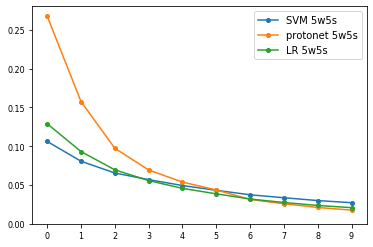

In [42]:
for name, est in variance_stat.items():
    if '5w5s' in name and 'test' not in name:
        plt.plot(est[:10], label=name, marker='o', markersize=4)
plt.xticks(np.arange(0, 10), size=8)
plt.yticks(np.arange(0, 0.3, 0.05), size=8)
plt.legend()
plt.show()

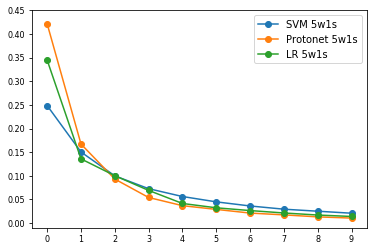

In [41]:
for name, est in variance_stat.items():
    if '5w1s' in name and 'test' not in name:
        plt.plot(est[:10], label=name, marker='o')
plt.xticks(np.arange(0, 10), size=8)
plt.yticks(np.arange(0, 0.5, 0.05), size=8)
plt.legend()
plt.show()

## simulations

In [14]:
import numpy as np

In [15]:
def sample(mu_1, mu_2, sigmas, n_samples=1):
    sample_1 = sigmas * np.random.randn(n_samples, 2) + mu_1
    sample_2 = sigmas * np.random.randn(n_samples, 2) + mu_2
    return sample_1, sample_2

In [16]:
mu_1 = np.array([0. , 0.])
mu_2 = np.array([8. , 0.])

In [17]:
sigma_base = np.arange(0.1, 2.0, 0.5)
sigma_ratio = np.arange(1., 10., 1.)

In [18]:
def compute_var(base, ratio, rev=False):
#     sigmas = np.arange(sigma_base, sigma_ratio*sigma_base, (sigma_ratio*sigma_base)/2.)
    sigmas = [base, base * ratio]
    if rev:
        sigmas = sigmas[::-1]
    perf = []
    for _ in range(1000):
        sample_1, sample_2 = sample(mu_1, mu_2, sigmas)
        lr = LogisticRegression(penalty='none', tol=1e-10, max_iter=1000)
        lr.fit(np.concatenate([sample_1, sample_2]), np.array([0, 1]))
        test_samples_1, test_samples_2 = sample(mu_1, mu_2, sigmas, n_samples=1000)
        correct = sum(lr.predict(test_samples_1) == 0) + sum(lr.predict(test_samples_2) == 1)
        perf.append(correct / 2000)
    return np.mean(perf), np.var(perf)        
    

In [19]:
hyp_var = {}
for base in sigma_base:
    hyp_var[base] = {} 
    for ratio in sigma_ratio:
        hyp_var[base][ratio] = compute_var(base, ratio)
        print("base:", base, "ratio:", ratio, "perf: mean,var", hyp_var[base][ratio])

base: 0.1 ratio: 1.0 perf: mean,var (1.0, 0.0)
base: 0.1 ratio: 2.0 perf: mean,var (1.0, 0.0)
base: 0.1 ratio: 3.0 perf: mean,var (0.999999, 4.989999999998905e-10)
base: 0.1 ratio: 4.0 perf: mean,var (0.9997985, 1.5776477499999925e-06)
base: 0.1 ratio: 5.0 perf: mean,var (0.9980555, 3.9277169749999996e-05)
base: 0.1 ratio: 6.0 perf: mean,var (0.9921155, 0.0002915564097500002)
base: 0.1 ratio: 7.0 perf: mean,var (0.9810654999999999, 0.0009158399597500002)
base: 0.1 ratio: 8.0 perf: mean,var (0.9689855, 0.0017248000397500002)
base: 0.1 ratio: 9.0 perf: mean,var (0.954413, 0.002966984431)
base: 0.6 ratio: 1.0 perf: mean,var (0.981779, 0.0007326326590000003)
base: 0.6 ratio: 2.0 perf: mean,var (0.8904185, 0.00781722210775)
base: 0.6 ratio: 3.0 perf: mean,var (0.8158395, 0.011606213489750002)
base: 0.6 ratio: 4.0 perf: mean,var (0.7643135, 0.01374689896775)
base: 0.6 ratio: 5.0 perf: mean,var (0.7288945, 0.013185077619750001)
base: 0.6 ratio: 6.0 perf: mean,var (0.7102645, 0.01298028628975)

In [20]:
hyp_var_2 = {}
for base in sigma_base:
    hyp_var_2[base] = {} 
    for ratio in sigma_ratio:
        hyp_var_2[base][ratio] = compute_var(base, ratio, rev=True)
        print(base, ratio, hyp_var_2[base][ratio])

0.1 1.0 (1.0, 0.0)
0.1 2.0 (1.0, 0.0)
0.1 3.0 (1.0, 0.0)
0.1 4.0 (0.999839, 1.6040789999999975e-06)
0.1 5.0 (0.998725, 2.8441874999999998e-05)
0.1 6.0 (0.995003, 0.00019537949099999996)
0.1 7.0 (0.9906115, 0.00046496431775000014)
0.1 8.0 (0.9830754999999999, 0.0010294565497499999)
0.1 9.0 (0.9759995, 0.0017689187497500001)
0.6 1.0 (0.9824674999999999, 0.0007076631937500001)
0.6 2.0 (0.934317, 0.003770126511000001)
0.6 3.0 (0.880742, 0.006127790436)
0.6 4.0 (0.829913, 0.009607808931000002)
0.6 5.0 (0.7901234999999999, 0.01402650449775)
0.6 6.0 (0.7517995000000001, 0.01551538054975)
0.6 7.0 (0.7020695, 0.025729793919750003)
0.6 8.0 (0.6810910000000001, 0.022604386219000003)
0.6 9.0 (0.6591835000000001, 0.021531235577750003)
1.1 1.0 (0.8737590000000001, 0.0070999909190000016)
1.1 2.0 (0.7948785, 0.01083185098775)
1.1 3.0 (0.7296545, 0.016176040879749998)
1.1 4.0 (0.6737274999999999, 0.02143557549375)
1.1 5.0 (0.645741, 0.019234213918999998)
1.1 6.0 (0.6092000000000001, 0.0192977375)
1.1 7

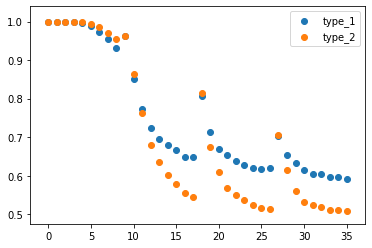

In [149]:
# for _, val in hyp_var_2.items():
plt.scatter(np.arange(len(hyp_var_type1)), np.array(hyp_var_type1)[:, 0], label='type_1', marker='o')
plt.scatter(np.arange(len(hyp_var_type2)), np.array(hyp_var_type2)[:, 0], label='type_2', marker='o')
# plt.scatter(np.array(hyp_var_2.values())[:, 0], label='type_2', marker='o')
#     plt.scatter(val[:, 0], label='mean', marker='o')
# plt.xticks(np.arange(0, 10), size=8)b
# plt.yticks(np.arange(0, 0.5, 0.05), size=8)
plt.legend()
plt.show()

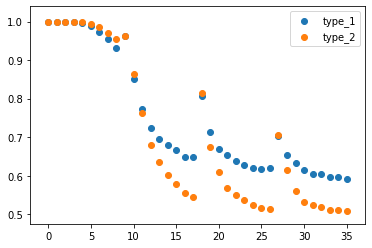

In [150]:
# for _, val in hyp_var_2.items():
plt.scatter(np.arange(len(hyp_var_type1)), np.array(hyp_var_type1)[:, 0], label='type_1', marker='o')
plt.scatter(np.arange(len(hyp_var_type2)), np.array(hyp_var_type2)[:, 0], label='type_2', marker='o')
# plt.scatter(np.array(hyp_var_2.values())[:, 0], label='type_2', marker='o')
#     plt.scatter(val[:, 0], label='mean', marker='o')
# plt.xticks(np.arange(0, 10), size=8)
# plt.yticks(np.arange(0, 0.5, 0.05), size=8)
plt.legend()
plt.show()

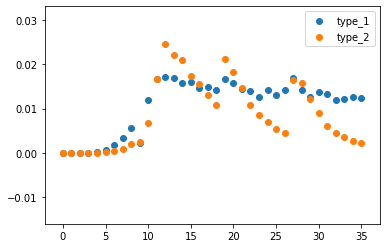

In [151]:
# for _, val in hyp_var_2.items():
plt.scatter(np.arange(len(hyp_var_type1)), np.array(hyp_var_type1)[:, 1], label='type_1', marker='o')
plt.scatter(np.arange(len(hyp_var_type2)), np.array(hyp_var_type2)[:, 1], label='type_2', marker='o')
# plt.scatter(np.array(hyp_var_2.values())[:, 0], label='type_2', marker='o')
#     plt.scatter(val[:, 0], label='mean', marker='o')
# plt.xticks(np.arange(0, 10), size=8)
# plt.yticks(np.arange(0, 0.5, 0.05), size=8)
plt.legend()
plt.show()

In [146]:
hyp_var_type2 = []
for base in sigma_base:
    for ratio in sigma_ratio:
        hyp_var_type2.append(hyp_var_2[base][ratio])